Coding the self-attention mechanism

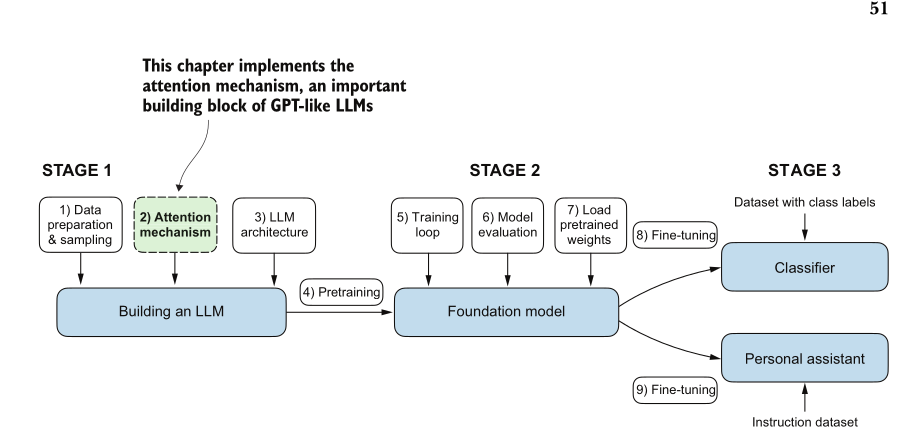

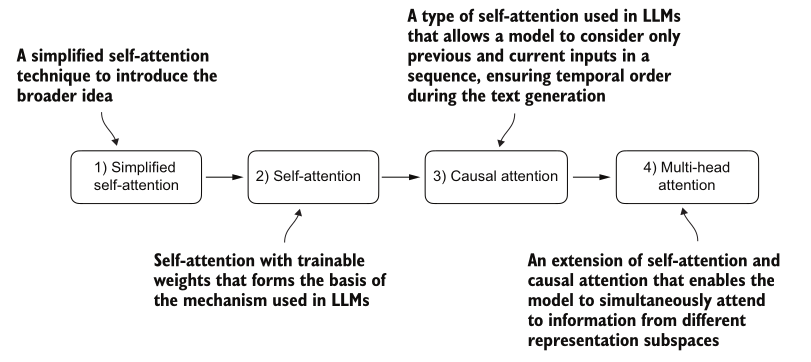

An RNN is a type of neural network where the output from previous steps is fed as input to the current step. This allows the network to maintain a form of memory, making it suitable for sequential data like text. However, RNNs can struggle with long-range dependencies and are often slow to train.

In [2]:
import torch

print(torch.__version__)

/home/mb/anaconda3/envs/py_env/lib/python3.14/site-packages/torch/_subclasses/functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


2.9.0+cu128


In an encoder–decoder RNN, the input text is fed into the encoder, which processes it sequentially. The encoder updates its hidden state (the internal values at the hidden layers) at each step, trying to capture the entire meaning of the input sentence in the final hidden state. The decoder then takes this final hidden state to start generating the translated sentence, one word at a time. It also updates its hidden state at each step, which is supposed to carry the context necessary for the next-word prediction.

RNNs work fine for translating short sentences, they don’t work well for lon-
ger texts as they don’t have direct access to previous words in the input. One major
shortcoming in this approach is that the RNN must remember the entire encoded
input in a single hidden state before passing it to the decoder. 
Hence, researchers developed the Bahdanau attention mechanism, which allows the decoder to focus on different parts of the input sequence at each step of the output generation. This is achieved by computing a set of attention weights that determine the importance of each input token for the current output token being generated.

A simple self-attention mechanism without trainable weights

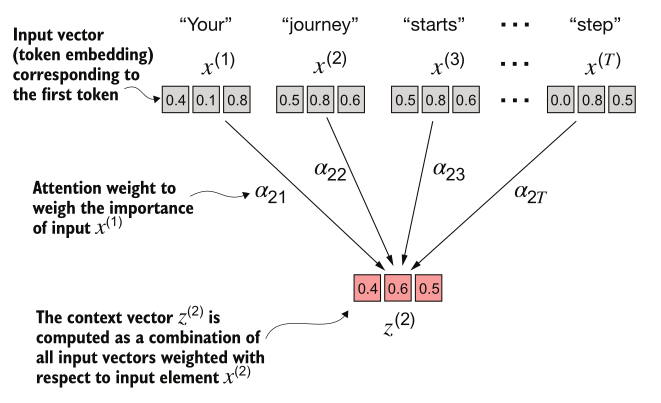

The goal of self-attention is to compute a context vector for each input element that combines information from all other input elements. In this example, we compute the context vector z(2). The importance or contribution of each input element for computing z(2) is determined by the attention weights 21 to 2T. When computing z(2), the attention weights are calculated with respect to input element x(2) and all other inputs.

We can think of the context vector as an enriched embedding vector that captures the relevant information of one element in relation to all other elements in the input sequence, allowing the model to make more informed predictions for each output token.

In [3]:
import torch

inputs = torch.tensor(
    [[0.43, 0.15, 0.89],
     [0.55, 0.87, 0.66],
     [0.57, 0.85, 0.64],
     [0.22, 0.58, 0.33],
     [0.77, 0.25, 0.10],
     [0.05, 0.80, 0.55]]
)

the first intermediate step is to compute the attention scores.
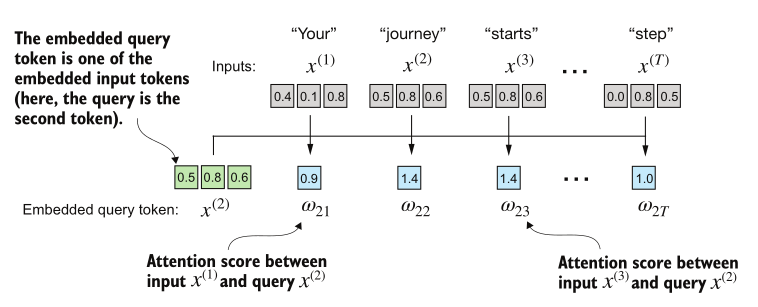

In [4]:
query = inputs[1]
attention_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attention_scores_2[i] = torch.dot(x_i, query)
print(attention_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [5]:
# next step is to normalize each of the attention scores. This is to obtain the attention weights which should sum to 1. this is useful for interpretation and maintaining training stability.

attention_weights_2_tmp = attention_scores_2 / attention_scores_2.sum()
print("Attention weights: ", attention_weights_2_tmp)
print("Sum: ", attention_weights_2_tmp.sum())

Attention weights:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)


in practice, you would use a softmax function to compute the attention weights. This ensures that the weights are positive and sum to 1.

In [6]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attention_scores_2_naive = softmax_naive(attention_scores_2)
print("Attention weights (naive softmax): ", attention_scores_2_naive)
print("Sum: ", attention_scores_2_naive.sum())

Attention weights (naive softmax):  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


this naive softmax implementation (softmax_naive) may encounter
numerical instability problems, such as overflow and underflow, when dealing with
large or small input values. Therefore, in practice, it’s advisable to use the PyTorch
implementation of softmax, which has been extensively optimized for performance:

In [7]:
attention_weights_2 = torch.softmax(attention_scores_2, dim=0)
print("Attention weights (PyTorch softmax): ", attention_weights_2)
print("Sum: ", attention_weights_2.sum())

Attention weights (PyTorch softmax):  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


In [8]:
# now we can calculate the context vector by multiplying the embedded input tokens with the attention weights and then summing the resulting vectors

query = inputs[1]
context_vector_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vector_2 += attention_weights_2[i] * x_i
print("Context vector: ", context_vector_2)

Context vector:  tensor([0.4419, 0.6515, 0.5683])


Computing attention weights for all input tokens

now, we have computed the context vector for the second input token. now we can compute the context vectors for all the input tokens.

In [9]:
attention_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attention_scores[i,j] = torch.dot(x_i, x_j)
print("Attention scores: ", attention_scores)

Attention scores:  tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [10]:
# when computing the preceding attention score tensor, we used a for-loop. this is not the most efficient way to compute the attention scores. we can use matrix multiplication to compute the attention scores more efficiently.

attention_scores = inputs @ inputs.T
print("Attention scores: ", attention_scores)


Attention scores:  tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [11]:
attention_weights = torch.softmax(attention_scores, dim=-1)
print("Attention weights: ", attention_weights)

Attention weights:  tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [12]:
row_2_sum = attention_weights[1].sum()
print("Row 2 sum: ", row_2_sum)
print("Sum of all rows: ", attention_weights.sum(dim=-1))

Row 2 sum:  tensor(1.)
Sum of all rows:  tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [13]:
all_context_vectors = attention_weights @ inputs
print(all_context_vectors)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


implementing self-attention with trainable weights

the most notable difference is the introduction of weight matrices that are updated during training. These weights are crucial so that the model can learn to produce the correct context vectors.

We  will  implement  the  self-attention  mechanism  step  by  step  by  introducing  the three trainable weight matrices Wq, Wk, and Wv. These three matrices are used to project the embedded input tokens, x
(i), into query, key, and value vectors, respectively

![Screenshot From 2025-10-31 05-44-44.png](<attachment:Screenshot From 2025-10-31 05-44-44.png>)
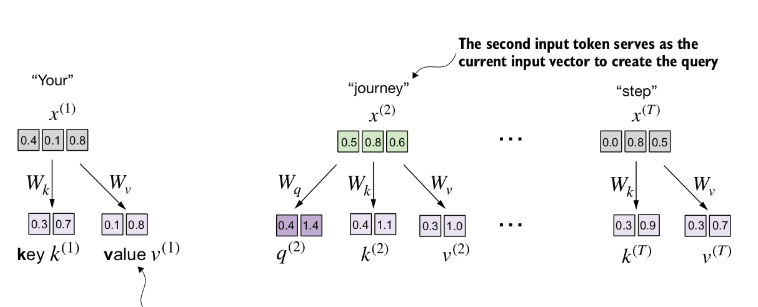

In [14]:
x_2 = inputs[1] #the second input element
d_in = inputs.shape[1] # the input embedding dimension d=3
d_out = 2 # the output embedding dimension d=2

In [15]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
# we set the requires_grad attribute to False to reduce
# clutter in the outputs, but if we were to use the
# weight matrices in the training process, we would set it to True
# to update them

In [16]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print("Query:", query_2)

Query: tensor([0.4306, 1.4551])


### Weight parameters vs. attention weights 
In the weight matrices W, the term “weight” is short for “weight parameters,” the values of a neural network that are optimized during training. This is not to be confused with the attention weights. As we already saw, attention weights determine the extent to which a context vector depends on the different parts of the input (i.e., to what extent the network focuses on different parts of the input). 
In summary, weight parameters are the fundamental, learned coefficients that define
the network’s connections, while attention weights are dynamic, context-specific values.


In [17]:
keys = inputs @ W_key
values = inputs @ W_value
print("Keys.shape:", keys.shape)
print("Values.shape:", values.shape)

Keys.shape: torch.Size([6, 2])
Values.shape: torch.Size([6, 2])


In [18]:
# now we compute the attention scores
keys_2 = keys[1]
attention_scores_22 = query_2.dot(keys_2)
print("Attention scores:", attention_scores_22)

Attention scores: tensor(1.8524)


In [19]:
attention_scores_2 = query_2 @ keys.T
print("Attention scores:", attention_scores_2)

Attention scores: tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


as we can see, the second element in the output matches the attention score attention_scores_22 seen above.

now we want to go from the attention scores to the attention weights. we do this by scaling the attention scores and using the softmax function. However, now we scale the attention scores by dividing them by the square root of the dimensionality of the keys.

In [20]:
d_k = keys.shape[-1]
attention_weights_2 = torch.softmax(attention_scores_2 / d_k ** 0.5, dim=-1)
print("Attention weights:", attention_weights_2)

Attention weights: tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


final step is to compute the context vectors as a weighted sum over the value vectors

In [21]:
context_vector_2 = attention_weights_2 @ values
print("Context vector:", context_vector_2)

Context vector: tensor([0.3061, 0.8210])


Implementing the self-attention python class

In [22]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attention_scores = queries @ keys.T #omega
        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1] ** 0.5, dim=-1
        )
        context_vector = attention_weights @ values
        return context_vector

In this PyTorch code, SelfAttention_v1 is a class derived from nn.Module, which is a
fundamental building block of PyTorch models that provides necessary functionalities
for model layer creation and management. 
 The __init__ method initializes trainable weight matrices (W_query, W_key, and
W_value) for queries, keys, and values, each transforming the input dimension d_in to
an output dimension d_out. 
  During  the  forward  pass,  using  the  forward  method,  we  compute  the  attention
scores (attention_scores) by multiplying queries and keys, normalizing these scores using
softmax. Finally, we create a context vector by weighting the values with these normal-
ized attention scores.

In [23]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


as a quick check, we notice that the second row ([0.3061, 0.8210]) matches the contents of context_vector_2 in the last section

Self-Attention class using PyTorch's Linear layers~

In [24]:
import torch.nn as nn

class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attention_scores = queries @ keys.T #omega
        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1] ** 0.5, dim=-1
        )
        context_vector = attention_weights @ values
        return context_vector

In [25]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


### Hiding future words with causal attention
Causal attention or masked attention is a form of self-attention that restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores. This is different from the standard self-attention mechanism which allows the model to access the whole sequence at once..
We will modify our standard s-a mechanism which is essential for LLMs

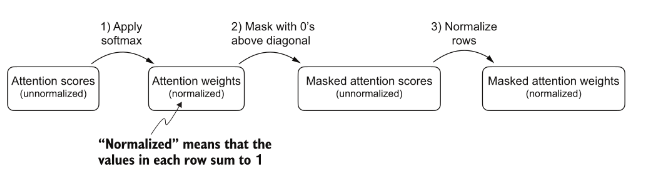

In [26]:
# first step is to compute the attention weights using the softmax function

queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
print("Attention weights:", attention_weights)

Attention weights: tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [28]:
# next we use PyTorch's tril function to create a lower triangular matrix to mask out future tokens in the attention weights matrix

context_length = attention_scores.shape[0]
mask_simple = torch.tril(torch.ones((context_length, context_length)))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [29]:
masked_simple = attention_weights * mask_simple
print("Masked attention weights:", masked_simple)

Masked attention weights: tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [31]:
# third step is to renormalize the masked attention weights so that they sum to 1
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_normalized = masked_simple / row_sums
print(masked_simple_normalized)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


A more efficient way to implement the causal attention is to use a math property of the softmax function.
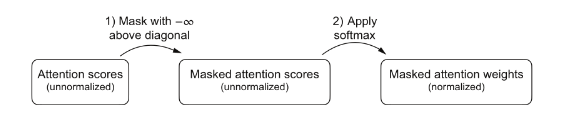

In [32]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attention_scores.masked_fill(mask.bool(), float('-inf'))
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [33]:
# now we apply the softmax function to obtain the masked attention weights

attention_weights = torch.softmax(masked / keys.shape[-1] ** 0.5, dim=-1)
print(attention_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### masking additional attention weights with dropout
dropout in deep learning is a technique where randomly selected hidden layer units are ignored during training (dropping them out). this method helps to prevent overfitting by ensuring that a model does not become too reliant on any specific set of hidden units. dropout is ONLY used during training and is disabled after.

In [34]:
torch.manual_seed(123)
dropout = nn.Dropout(p=0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [35]:
torch.manual_seed(123)
print(dropout(attention_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


Implementing a compact causal attention class

In [36]:
batch = torch.stack((inputs, inputs), dim=0)  # shape (2, 6, 3)
print("Batch shape:", batch.shape)

Batch shape: torch.Size([2, 6, 3])


In [37]:
# this class is similar to the previous SelfAttention_v2 class but includes causal masking and dropout for regularization

class CausalSelfAttention(nn.Module):
    def __init__(self, d_int, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_int, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_int, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_int, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)

        # create the causal mask once during initialization
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)      # shape (b, num_tokens, d_out)
        queries = self.W_query(x) # shape (b, num_tokens, d_out)
        values = self.W_value(x)  # shape (b, num_tokens, d_out
        
        attention_scores = queries @ keys.transpose(1,2)
        attention_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], float('-inf'))
        attention_weights = torch.softmax(
            attention_scores / d_in ** 0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)
        
        context_vector = attention_weights @ values
        return context_vector


In [38]:
torch.manual_seed(123)
context_length = batch.shape[1]
causal_sa = CausalSelfAttention(d_in, d_out, context_length, 0.0)
context_vectors = causal_sa(batch)

print("context_vectors shape:", context_vectors.shape)

context_vectors shape: torch.Size([2, 6, 2])


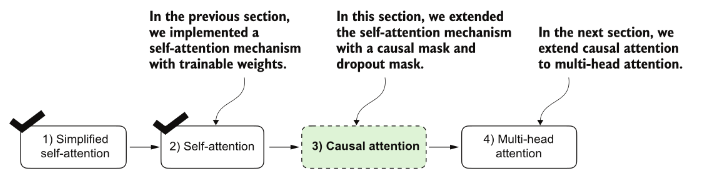

### Extending single-head attention to multi-head attention
The term "multi-head" refers to dividing the attention mechanism into multiple "heads", each operating independently. A single causal attention module can be considered single-head attention where there is onlu one set of attention weights processing the input sequentially. We will build this by stacking multiple causal-attention modules. Then we will implement the same multi-head attention module in a more complicated but efficient way.

In [39]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalSelfAttention(
                d_in, d_out, context_length, dropout, qkv_bias
            ) for _ in range(num_heads)]
        )
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0,  num_heads=2)
context_vectors = mha(batch)

print(context_vectors)
print("context_vectors shape:", context_vectors.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5866,  0.0071,  0.5869,  0.3214],
         [-0.6293, -0.0621,  0.6184,  0.3825],
         [-0.5670, -0.0838,  0.5474,  0.3575],
         [-0.5519, -0.0979,  0.5319,  0.3423],
         [-0.5295, -0.1077,  0.5074,  0.3481]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5866,  0.0071,  0.5869,  0.3214],
         [-0.6293, -0.0621,  0.6184,  0.3825],
         [-0.5670, -0.0838,  0.5474,  0.3575],
         [-0.5519, -0.0979,  0.5319,  0.3423],
         [-0.5295, -0.1077,  0.5074,  0.3481]]], grad_fn=<CatBackward0>)
context_vectors shape: torch.Size([2, 6, 4])


implementing multi-head attention with weight splits

In [52]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0, "d_out must be divisible by num_heads")
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)      # shape (b, num_tokens, d_out)
        queries = self.W_query(x) # shape (b, num_tokens, d_out)
        values = self.W_value(x)  # shape (b, num_tokens, d_out)

        # reshape for multi-head attention
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        
        keys = keys.transpose(1,2)      # shape (b, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1,2) # shape (b, num_heads, num_tokens, head_dim)
        values = values.transpose(1,2)  # shape (b


        attention_scores = queries @ keys.transpose(2,3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        
        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1] ** 0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)
        
        context_vector = (attention_weights @ values).transpose(1,2)
        
        context_vector = context_vector.contiguous().view(b, num_tokens, self.d_out)
        
        context_vector = self.out_proj(context_vector)
        return context_vector
    

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_92710/3179064556.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (d_out % num_heads == 0, "d_out must be divisible by num_heads")


In [53]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vectors = mha(batch)
print(context_vectors)
print("context_vectors shape:", context_vectors.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vectors shape: torch.Size([2, 6, 2])


Attention mechanisms transform input elements into enhanced context vector
representations that incorporate information about all inputs.
* A self-attention mechanism computes the context vector representation as a
weighted sum over the inputs.
In a simplified attention mechanism, the attention weights are computed via
dot products.
A dot product is a concise way of multiplying two vectors element-wise and then
summing the products.
Matrix multiplications, while not strictly required, help us implement computa-
tions more efficiently and compactly by replacing nested for loops.
In self-attention mechanisms used in LLMs, also called scaled-dot product
attention, we include trainable weight matrices to compute intermediate trans-
formations of the inputs: queries, values, and keys.
When working with LLMs that read and generate text from left to right, we add
a causal attention mask to prevent the LLM from accessing future tokens.
In addition to causal attention masks to zero-out attention weights, we can add
a dropout mask to reduce overfitting in LLMs.
The attention modules in transformer-based LLMs involve multiple instances of
causal attention, which is called multi-head attention.
We can create a multi-head attention module by stacking multiple instances of
causal attention modules.
A more efficient way of creating multi-head attention modules involves batched
matrix multiplications.